In [1]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# loading the dataset
dataset = pd.read_csv('/content/drive/MyDrive/fake reviews dataset.csv')

In [6]:
# get the list of class names
class_names = list(np.unique(dataset["label"]))
class_names

['CG', 'OR']

In [7]:
# tranfer the labels into number labels
encoder = OrdinalEncoder()
dataset["label"] = encoder.fit_transform(dataset[["label"]])

In [8]:
# Split the dataset into 3 parts
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(32345, 4) (4043, 4) (4044, 4)


In [9]:
# create the class of Dataset
class FakeReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation = True,
            pad_to_max_length=True,
            return_tensors='pt',
            )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)}

In [10]:
# create the dataloader to design the dataset through batch size
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = FakeReviewDataset(
        reviews = df.text_.to_numpy(),
        targets = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size)

In [11]:
# set the parameter for the Dataset and DataLoader
MAX_LEN = 160
BATCH_SIZE = 64
# Set the model name
MODEL_NAME = 'bert-base-uncased'
# Build a BERT based tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
#just using the test set to evaluate the model 4
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
# load Model 1
model_1 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model_1.to(device)
model_1.load_state_dict(torch.load('/content/drive/MyDrive/DL_model_1.pth'))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [14]:
# load Model 2
model_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model_2.to(device)
model_2.load_state_dict(torch.load('/content/drive/MyDrive/DL_model_2.pth'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [14]:
# Load Model 3
model_3 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model_3.to(device)
model_3.load_state_dict(torch.load('/content/drive/MyDrive/DL_model_3.pth'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## Model 4-1

In [ ]:
# create the function to evaluate the Model 4
def test_set_predictions_prob(model1,model2,model3, data_loader):
    model1 = model1.eval()
    model2 = model2.eval()
    model3 = model3.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs_1 = model1(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets)

            outputs_2 = model2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets)

            outputs_3 = model3(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets)

            logits_1 = outputs_1.logits
            logits_2 = outputs_2.logits
            logits_3 = outputs_3.logits

            prob_1 = F.softmax(logits_1, dim=1)
            prob_2 = F.softmax(logits_2, dim=1)
            prob_3 = F.softmax(logits_3, dim=1)

            # design the evaluate function based on the sum of probability
            prob = prob_1 + prob_2 + prob_3
            label = torch.argmax(prob, dim=-1)

            preds_1 = torch.argmax(logits_1, dim=-1)
            preds_2 = torch.argmax(logits_2, dim=-1)
            preds_3 = torch.argmax(logits_3, dim=-1)

            # design the evaluate function based on majority vote
            preds = preds_1 + preds_2 + preds_3
            labels = torch.where(preds > 1, torch.tensor(1), torch.tensor(0))

            predictions.extend(labels)
            prediction_probs.extend(label)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = test_set_predictions_prob(
    model_1, model_2, model_3,
    test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.95      0.99      0.97      2017
          OR       0.99      0.95      0.97      2027

    accuracy                           0.97      4044
   macro avg       0.97      0.97      0.97      4044
weighted avg       0.97      0.97      0.97      4044



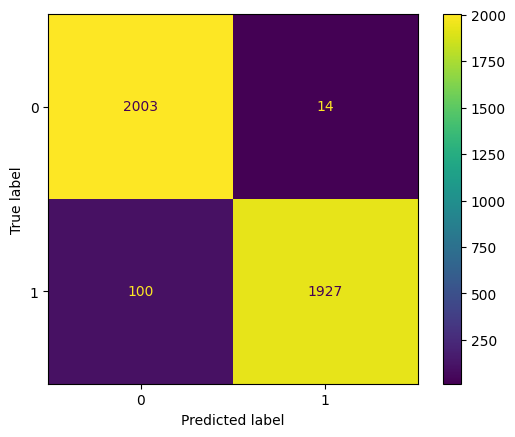

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred_probs, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.95      0.99      0.97      2017
          OR       0.99      0.95      0.97      2027

    accuracy                           0.97      4044
   macro avg       0.97      0.97      0.97      4044
weighted avg       0.97      0.97      0.97      4044



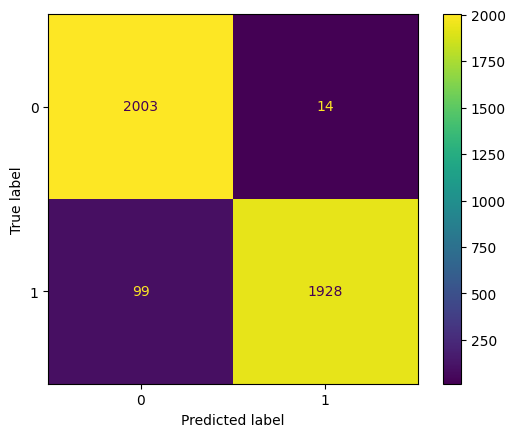

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_probs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Model 4-2

In [25]:
# create the function to evalate the Model 4
def test_set_predictions_prob(model1,model3, data_loader):
    model1 = model1.eval()
    model3 = model3.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs_1 = model1(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets)

            outputs_3 = model3(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets)

            logits_1 = outputs_1.logits
            logits_3 = outputs_3.logits

            prob_1 = F.softmax(logits_1, dim=1)
            prob_3 = F.softmax(logits_3, dim=1)

            # design the evaluate function based on the sum of probability
            prob = prob_1 + prob_3
            label = torch.argmax(prob, dim=-1)

            preds_1 = torch.argmax(logits_1, dim=-1)
            preds_3 = torch.argmax(logits_3, dim=-1)

            # design the evaluate function based on majority vote
            preds = preds_1 + preds_3
            labels = torch.where(preds > 0, torch.tensor(1), torch.tensor(0))

            predictions.extend(labels)
            prediction_probs.extend(label)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probs, real_values

In [21]:
y_pred, y_pred_probs, y_test = test_set_predictions_prob(
    model_1, model_3,
    test_data_loader)

### Based on the majority vote

In [22]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.98      0.99      0.98      2017
          OR       0.99      0.97      0.98      2027

    accuracy                           0.98      4044
   macro avg       0.98      0.98      0.98      4044
weighted avg       0.98      0.98      0.98      4044



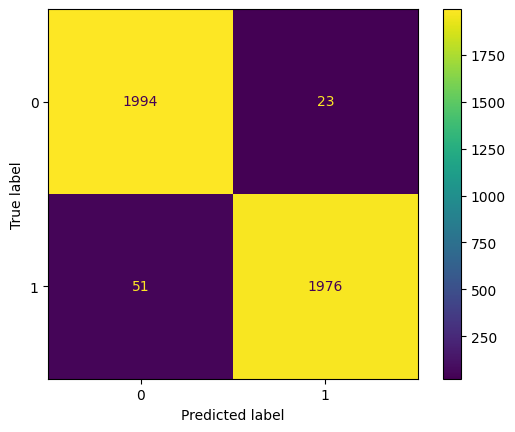

In [23]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Based on probability

In [18]:
print(classification_report(y_test, y_pred_probs, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.96      0.99      0.98      2017
          OR       0.99      0.96      0.98      2027

    accuracy                           0.98      4044
   macro avg       0.98      0.98      0.98      4044
weighted avg       0.98      0.98      0.98      4044



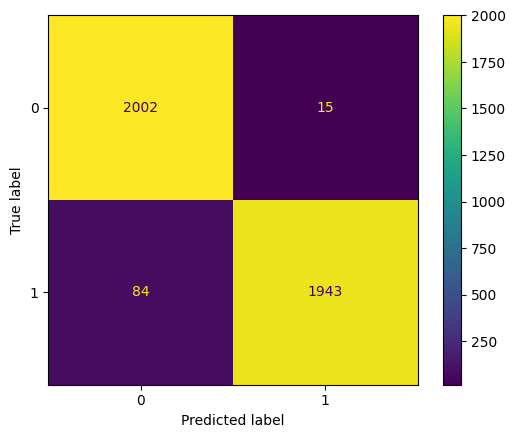

In [24]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_probs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# memory using for this Model
info_memory = torch.cuda.mem_get_info()
memory = info_memory[1] - info_memory[0]
print("The total used memory is ", round(memory/2**30,2)," GB.")

The total used memory is  3.06  GB.
